# VGGNet

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
# check if gpu present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets, transforms and visualisations

Transformations
*   Resizing: Since the NN takes 224 x 224 as its input
*   Crop: Crops at a random location into 224 x 224
*   ToTensor: (as usual)
*   Normalize: ( new thing ) setting mean and standard deviation, of the matrix of 3 channels so as to bring range to uniform value.

All are pipelined - from one to another

In [4]:
# earlier had used ToTensor() of "transform" to convert PIL image to tensor directly
# This time using few more functions of "transform"

transform_train = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Downloading and applying the transform object pipelined above

In [5]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, 
                                        transform = transform_train) # applying transform in this last line

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, 
                                        transform = transform_test)
                                        

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
num_classes = 10

10 classes in CIFAR10

In [7]:
batch_size = 4

visualise 4 at a time

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# want shuffled instances of 4 images

In [9]:
dataiter = iter(trainloader)
images , labels = dataiter.next() # gives next batch

print(images.shape)

print(images[1].shape)
print(labels[1].item()) # class

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


Note 32 x 32 of CIFAR has been converted to 224 x 224

In [10]:
# to display image
# only change: unnormalize => multiplication by 0.5 (std. dev) and adding by 0.5 (mean)
# to unnormalize, convert image to numpy
# if don't normalize, too dark, since normalizing had reduced all the color intensity etc
def imshow(img, title):
  npimg = img.numpy()
  plt.figure(figsize = (batch_size, 1))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1,2,0))) # i.e. putting the 3 channels at end
  plt.title(title)
  plt.show()


In [11]:
# Show the entire batch together
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


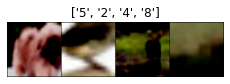

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


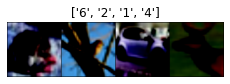

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


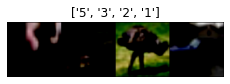

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


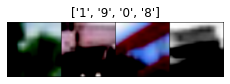

In [12]:
for i in range(4):
  show_batch_images(trainloader)

# Creating VGG-16

Unlike LeNet, PyTorch itself defines.  
AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception v3, GoogLeNet, ShuffleNet v2, MobileNet v2, ResNeXt, Wide ResNet, MNASNet. These are open source, all built using - nn.Linear, nn.ReLu, nn.Dropout, nn.forward, avgpool, padding, stride, reshaping, etc

In [13]:
from torchvision import models

In [14]:
vgg = models.vgg16_bn()

Shows all operations performed

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Features + AvgPool + Classifier

In [16]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [17]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


How to change number of classes in model (by defualt, 1000 - see last line of classifier). 2 ways:  
*   Pass num_of_classes as argument to VGG
*   Create own classifier (only last classifier)

We don't want VGG to instantiate so many unnecessary weights corresponding to the 10 classes. So change even input_features, (only output not sufficient).

In [18]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1] # modified classifier: should have same number of inputs as actual classifier, but ouptut size we fix
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # extend all previous classifiers, then add our one to end
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In-features remain 25088  
Out-features is now 10

In [19]:
vgg.classifier = nn.Sequential(*mod_classifier) # tell VGG to use the modified classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train CIFAR10

Batch Size = 16 (ideal)

In [40]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = False)

In [41]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1) # index at which max value
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

Note: Like previously our classifier doens't have the softmax layer, since that's taken care of by the loss function (nn.CrossEntropyLoss) that knows that there is a softmax at the end.

In [42]:
# Shift everything to gpu
# model to gpu
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05) # optimiser: stochastic grad desc

Loss: Cross Entropy  
Strategy: Stochastic Gradient Descent   
Optimizer: Vanilla (Optionally if you mention nesterov=True, it'll use NAG)  
Activation function: ReLU (VGG uses this)  
Regularisation: Not used here (can pass L2 to optim.SGD)

Other optimizers other than torch.optim.SGD which uses Vanilla:  
torch.optim.Adagrad   
torch.optim.Adam (what we used in LeNet)  
torch.optim.RMSprop

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

# usual learning loop
for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    # forward pass
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)

    # calculate loss
    loss = loss_fn(outputs, labels)

    # backward pass
    loss.backward() # loss is just functions of those basic params (w, b) so loss.backward() means apply chain rule on loss w.r.t. w and b one step at a time

    # Update params
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache() # empty cache and delete variables since they occupy very large space - very crucial to use less space for such large number of params

    if i%100 == 0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc = %0.2f, Train acc = %0.2f'%(epoch, max_epochs,evaluation(testloader, vgg), evaluation(trainloader, vgg)))
  
  plt.plot(loss_epoch_arr)
  plt.show()

Iteration: 0/3125, Loss: 2.59
Iteration: 100/3125, Loss: 2.20
Iteration: 200/3125, Loss: 2.04
Iteration: 300/3125, Loss: 2.14
Iteration: 400/3125, Loss: 2.45
Iteration: 500/3125, Loss: 2.37
Iteration: 600/3125, Loss: 2.40
Iteration: 700/3125, Loss: 2.26
Iteration: 800/3125, Loss: 2.18
Iteration: 900/3125, Loss: 2.02
Iteration: 1000/3125, Loss: 2.20
Iteration: 1100/3125, Loss: 2.30
Iteration: 1200/3125, Loss: 2.27
Iteration: 1300/3125, Loss: 2.21
Iteration: 1400/3125, Loss: 2.34
Iteration: 1500/3125, Loss: 2.05
Iteration: 1600/3125, Loss: 1.94
Iteration: 1700/3125, Loss: 1.93
Iteration: 1800/3125, Loss: 1.99
Iteration: 1900/3125, Loss: 1.99
Iteration: 2000/3125, Loss: 1.88
Iteration: 2100/3125, Loss: 2.01
Iteration: 2200/3125, Loss: 2.04


# Freeze layers of Convolutional Neural Network (Pre-trained models)

138 million parameters in model + 500 images per class - looong time! So use pre-trained

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = False)

In [ ]:
# pre-trained contains not only model architecture, but even optimised weights and parameters. It was trained on the "imagenet problem"
vgg = models.vgg16_bn(pretrained = True) # pretrained = true

Not only instantiating the different layers but downloading the different params as well! 138 million params

In [ ]:
for param in vgg.parameters():
  param.requires_grad = False
# i.e. if doing backprop, don't go and update weigths, they are already good

In [ ]:
# Method 1 to add own classifier layer
# final_in_features = vgg.classifier[6].in_features # the number of input features of 6th layer in model's classifier
# mod_classifier = list(vgg.classifier.children())[:-1]
# mod_classifier.extend(nn.Linear(final_in_features, num_classes))
# print(mod_classifier)

In [ ]:
# Method 2 to add own classifier layer
final_in_features = vgg.classifier[6].in_features
# learn only params of last layer (requires_grad = True), all other params - use those already trained for Image net only
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

Which layer requires update/undergoes learning of params

In [ ]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

Note without the if statement would have showed all layers. But now, shows only last layer of classifier - the only layer params to be learnt

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

In [ ]:
vgg = vgg.to(device)

Since current downloaded model trained for ImageNet that has 1000 classes, while ours has 100 classes; alter this layer the same way.

Once requires_grad is false => number of computations also decreases

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

# usual learning loop
for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    # forward pass
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)

    # backward pass
    loss.backward() # loss is just functions of those basic params (w, b) so loss.backward() means apply chain rule on loss w.r.t. w and b one step at a time
    opt.step() # update paramas

    del inputs, labels, outputs
    torch.cuda.empty_cache() # empty cache and delete variables since they occupy very large space - very crucial to use less space for such large number of params

    if i%100 == 0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print("Epoch: %d/%d, Test acc = %0.2f, Train acc = %0.2f")%(
      epoch, max_epochs,
      evaluation(testloader, vgg), evaluation(trainloader, vgg))
  
  plt.plot(loss_epoch_arr)
  plt.show()

Much much lesser time this time

# Checkpointing

Save all model params so that what's learnt isn't lost.

In [ ]:
import copy

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

# keeps record of min loss
min_loss = 1000

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)

    loss.backward() 
    opt.step() 

    if loss.item() < min_loss: # loss.item is the current loss
      min_loss = loss.item() 
      best_model = copy.deepcopy(vgg.state_dict()) # state_dict has all params of model
      print("Min loss %0.2f" % min_loss)

    if i%100 == 0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()


  loss_epoch_arr.append(loss.item())

  print("Epoch: %d/%d, Test acc = %0.2f, Train acc = %0.2f")%(
      epoch, max_epochs,
      evaluation(testloader, vgg), evaluation(trainloader, vgg))
  
  plt.plot(loss_epoch_arr)
  plt.show()

In [ ]:
# i.e. overriding the "vgg" variable with the best model (parameters), since you'll be using this variable to access the model henceforth
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testLoader, vgg))